In [1]:
# !pip install seaborn scikit-image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import glob
import skimage
import skimage.io as io
import pandas as pd

# 모든 경고 무시
warnings.filterwarnings("ignore")

In [2]:
# 테스트 이미지 경로
test_images = sorted(glob.glob("etest_images/*.png"))
fnames = [img.split('/')[-1] for img in test_images]

# 픽셀 간 간격 파일
df = pd.read_csv("spacings_etest.csv")
spacings = df['Spacing']

# 좌표 파일
data_GT = np.load("raw_results/etest/GT_xy_coordinate.npy")
data_UNet = np.load("raw_results/etest/Unet_xy_coordinate.npy")
data_RetinaNet = np.load("raw_results/etest/RetinaNet_xy_coordinate.npy")

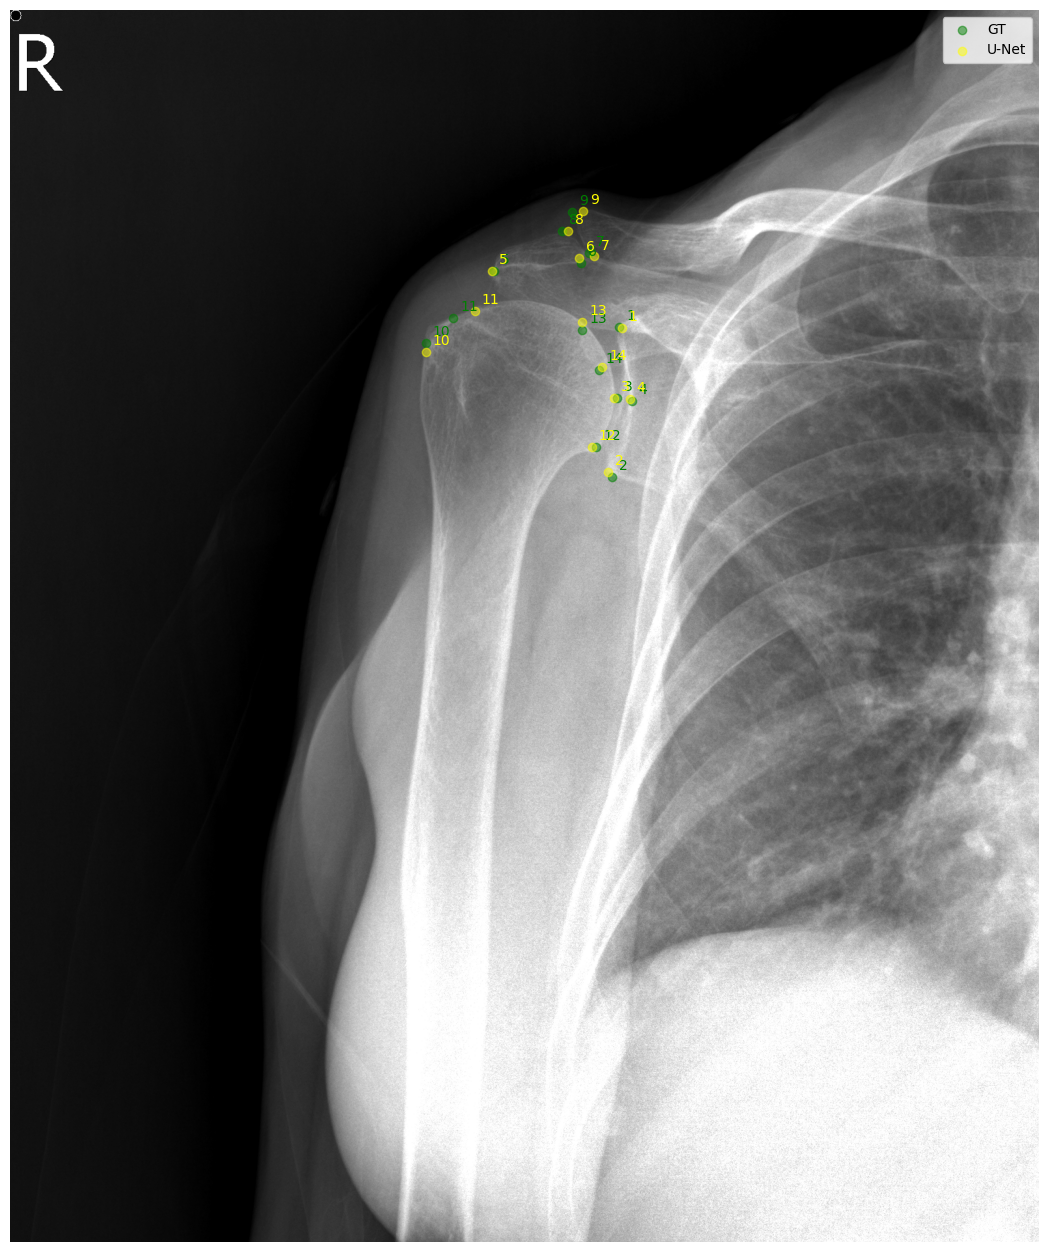

In [3]:
# 좌표 시각화
def show_(data, idx, label, color='black'):
    plt.scatter(data[idx, :, 0], data[idx, :, 1], label = label, alpha=0.5, color=color)

    # 각 점에 0부터 13까지의 숫자 표시
    for i in range(14):
        plt.annotate(str(i+1), (data[idx, i, 0], data[idx, i, 1]), 
                     xytext=(5, 5), textcoords='offset points', color=color)
        
    plt.xlabel('X axis')
    plt.ylabel('Y axis')
    plt.grid(True)
    plt.legend()
    plt.axis('off')


# 시각화
idx = 0 # 이미지 인덱스
img = skimage.io.imread(test_images[idx])
plt.figure(figsize=(16,16))
plt.imshow(img)

show_(data_GT,idx,'GT', 'green')
show_(data_UNet,idx,'U-Net', 'yellow')

In [4]:
def cal_angle_CSA(data):
    # 점1 - 점2 - 점5의 각도 측정
    angle = calculate_angle(data[0], data[1], data[4])
    return angle
        
def calculate_angle(p1, p2, p3):
    """
    세 점 p1, p2, p3의 좌표를 이용하여 p2를 꼭지점으로 하는 각도를 계산합니다.
    
    :param p1: (h, w) 형식의 첫 번째 점 좌표
    :param p2: (h, w) 형식의 두 번째 점 좌표 (각도의 꼭지점)
    :param p3: (h, w) 형식의 세 번째 점 좌표
    :return: 각도 (도 단위)
    """
    # 벡터 계산
    v1 = np.array([p1[1] - p2[1], p1[0] - p2[0]])
    v2 = np.array([p3[1] - p2[1], p3[0] - p2[0]])
    
    # 벡터의 내적
    dot_product = np.dot(v1, v2)
    
    # 벡터의 크기
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    # 코사인 값 계산
    cos_angle = dot_product / (magnitude_v1 * magnitude_v2)
    
    # 각도 계산 (라디안)
    angle_rad = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    
    # 라디안을 도로 변환
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

def cal_angle_LLA(data):
    # 1-2연장선 5-6연장선
    angle = calculate_angle_between_lines(data[0],data[1],data[4],data[5])
    return angle

def calculate_angle_between_lines(p1, p2, p3, p4):
    """
    4개의 점으로 정의된 두 직선 사이의 각도를 계산합니다.
    
    :param p1: (h, w) 형식의 첫 번째 직선의 첫 점
    :param p2: (h, w) 형식의 첫 번째 직선의 두 번째 점
    :param p3: (h, w) 형식의 두 번째 직선의 첫 점
    :param p4: (h, w) 형식의 두 번째 직선의 두 번째 점
    :return: 두 직선 사이의 각도 (도 단위)
    """
    # 각 직선의 방향 벡터 계산
    v1 = np.array([p2[1] - p1[1], p2[0] - p1[0]])
    v2 = np.array([p4[1] - p3[1], p4[0] - p3[0]])
    
    # 벡터의 내적
    dot_product = np.dot(v1, v2)
    
    # 벡터의 크기
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    # 코사인 값 계산
    cos_angle = dot_product / (magnitude_v1 * magnitude_v2)
    
    # 각도 계산 (라디안)
    angle_rad = np.arccos(np.clip(cos_angle, -1.0, 1.0))
    
    # 라디안을 도로 변환
    angle_deg = np.degrees(angle_rad)
    
    # 항상 예각 또는 직각을 반환하도록 조정
    if angle_deg > 90:
        angle_deg = 180 - angle_deg
    
    return angle_deg

def cal_angle_GI(data):
    #  (1-2연장선) - 수직선
    angle = calculate_angle_with_horizontal(data[0],data[1])
    if angle > 90:
        angle = 180 - angle
    return angle

def calculate_angle_with_horizontal(p1, p2):
    """
    두 점을 지나는 직선과 수평축 사이의 각도를 계산합니다.
    
    :param p1: (h, w) 형식의 첫 번째 점 좌표
    :param p2: (h, w) 형식의 두 번째 점 좌표
    :return: 직선과 수평축 사이의 각도 (도 단위, 0 ~ 180도)
    """
    # 두 점 사이의 변화량 계산
    dh = p2[0] - p1[0]  # 높이(h) 변화
    dw = p2[1] - p1[1]  # 너비(w) 변화
    
    # 아크탄젠트를 사용하여 각도 계산 (라디안)
    angle_rad = np.arctan2(dh, dw)
    
    # 라디안을 도로 변환
    angle_deg = np.degrees(angle_rad)
    
    return angle_deg

def cal_angle_HAN(data):
    # Humeral anatomical neck
    angle = calculate_angle_with_horizontal(data[10],data[11])
    if angle < 90:
        angle = 180 - angle
    return angle    

In [5]:
def cal_distance_AI(data, spacing):
    """
    점1-점2를 지나는 직선과 점5의 거리, 점1-점2를 지나는 직선과 점10의 거리를 계산합니다.
    
    :param data: (14, 2) 형태의 배열, 각 행은 (h, w) 좌표를 나타냄
    :return: (점5까지의 거리, 점10까지의 거리)
    """
    def point_to_line_distance(point, line_point1, line_point2, spacing):
        # 직선의 방향 벡터
        line_vec = line_point2 - line_point1
        # 점에서 직선의 첫 점까지의 벡터
        point_vec = point - line_point1
        
        # 직선의 길이
        line_length = np.linalg.norm(line_vec)
        
        # 점에서 직선까지의 거리 계산
        distance = np.abs(np.cross(line_vec, point_vec)) / line_length
        return distance * spacing
    
    p1, p2, p5, p10 = data[0], data[1], data[4], data[9]
    
    # 점5와 점10에서 직선까지의 거리 계산
    distance_p5 = point_to_line_distance(p5, p1, p2, spacing)
    distance_p10 = point_to_line_distance(p10, p1, p2, spacing)
    
    return distance_p5, distance_p10

def calculate_distance(p1, p2, spacing):
    """
    두 점 사이의 거리를 계산합니다.
    
    :param p1: (h, w) 형식의 첫 번째 점 좌표
    :param p2: (h, w) 형식의 두 번째 점 좌표
    :return: 두 점 사이의 거리
    """
    # 각 좌표 차이 계산
    dh = p2[0] - p1[0]  # 높이(h) 차이
    dw = p2[1] - p1[1]  # 너비(w) 차이
    
    # 유클리드 거리 계산
    distance = np.sqrt(dh**2 + dw**2)
    
    return distance * spacing

def calculate_distance_AC(data, spacing):
    # A-C distnace (6-7 길이) and (8-9 길이) 각각
    p6 = data[5]
    p7 = data[6]
    p8 = data[7]
    p9 = data[8]

    AC1 = calculate_distance(p6, p7, spacing)    
    AC2 = calculate_distance(p8, p9, spacing)

    return AC1, AC2

def calculate_distance_GT(data, spacing):
    # GT length (10-11)
    p10 = data[9]
    p11 = data[10]
    
    GT = calculate_distance(p10, p11, spacing)    
    return GT

def calculate_distance_RTL(data, spacing):
    # r(atio of the transverse to longitudinal diameter of glenoid projection)
    # (3-4길이) / (1-2길이)
    
    p1 = data[0]
    p2 = data[1]
    p3 = data[2]
    p4 = data[3]

    RTL1 = calculate_distance(p1, p2, spacing)    
    RTL2 = calculate_distance(p3, p4, spacing)
    return RTL1, RTL2

def calculate_relation_CG(data, spacing):
    """
    점13-점14의 중점에서 점1과 점2를 이은 직선에 수직한 선을 그었을 때 만나는 점의 위치를 계산합니다.    
    이 점 위치는 점1과 점2의 거리 대비 상대적 위치로 표현되며 음/양의 값을 가질 수 있습니다.
    
    :param data: (14, 2) 형태의 배열, 각 행은 (h, w) 좌표를 나타냄
    :param spacing: 픽셀 간 간격
    :return: 상대적 위치 (음수 또는 양수 값)
    """
    p1 = data[0]  # 점1의 좌표
    p2 = data[1]  # 점2의 좌표
    p13 = data[12]  # 점13의 좌표
    p14 = data[13]  # 점14의 좌표
    
    # 점13과 점14의 중점 계산
    mid_point = (p13 + p14) / 2
    
    # 점1에서 점2로 향하는 벡터
    line_vector = p2 - p1
    
    # 점1에서 중점으로 향하는 벡터
    point_vector = mid_point - p1
    
    # 직선 위로 중점을 수직 투영
    projection_scalar = np.dot(point_vector, line_vector) / np.dot(line_vector, line_vector)
    projection_point = p1 + projection_scalar * line_vector
    
    distance_projection = np.linalg.norm(projection_point - p1) * spacing
    distance_12 = np.linalg.norm(p2 - p1) * spacing
    relative_position = distance_projection / distance_12
    
    # 투영점이 p1보다 앞에 있으면 음수 값으로 표현
    if np.dot(projection_point - p1, p2 - p1) < 0:
        relative_position = -relative_position
    
    return relative_position

In [7]:
# 좌표기반 측정 데이터 저장
def analysis_data(data, path_name_csv):
    
    CSAs = []
    LLAs = []
    GIs = []
    HANs = []
    GAs = []
    GHs = []
    AC1s = []
    AC2s = []
    GTs = []
    RTL1s = []
    RTL2s = []
    CGs = []

    for idx in range(len(data)):
        spacing = spacings[idx]

        CSA = cal_angle_CSA(data[idx])
        LLA = cal_angle_LLA(data[idx])
        GI = cal_angle_GI(data[idx])
        HAN = cal_angle_HAN(data[idx])
        GA, GH = cal_distance_AI(data[idx], spacing)
        AC1, AC2 = calculate_distance_AC(data[idx], spacing)
        GT = calculate_distance_GT(data[idx], spacing)
        RTL1, RTL2 = calculate_distance_RTL(data[idx],spacing)
        CG = calculate_relation_CG(data[idx], spacing)

        CSAs.append(CSA)
        LLAs.append(LLA)
        GIs.append(GI)
        HANs.append(HAN)

        GAs.append(GA)
        GHs.append(GH)
        AC1s.append(AC1)
        AC2s.append(AC2)
        GTs.append(GT)
        RTL1s.append(RTL1)
        RTL2s.append(RTL2)
        CGs.append(CG)

    if len(fnames)!= len(CSAs):
        df = pd.DataFrame({
            'fname': fnames[:len(CSAs)],
            'CSA': CSAs,
            'LLA': LLAs,
            'GI': GIs,
            'HAN': HANs,
            'GA': GAs,
            'GH': GHs,
            'AC1': AC1s,
            'AC2': AC2s,
            'GT': GTs,
            'RTL1': RTL1s,
            'RTL2': RTL2s,
            'CG': CGs
        })

    else:
        df = pd.DataFrame({
            'fname': fnames,
            'CSA': CSAs,
            'LLA': LLAs,
            'GI': GIs,
            'HAN': HANs,
            'GA': GAs,
            'GH': GHs,
            'AC1': AC1s,
            'AC2': AC2s,
            'GT': GTs,
            'RTL1': RTL1s,
            'RTL2': RTL2s,
            'CG': CGs
        })

    df.to_csv(f'{path_name_csv}.csv', index=False)

analysis_data(data_GT, 'final_results/etest/GT_analysis_data')
# analysis_data(data_R1, 'final_results/R1_analysis_data')
# analysis_data(data_R2, 'final_results/R2_analysis_data')
# analysis_data(data_GT_1, 'final_results/GT_1_analysis_data')
# analysis_data(data_R1_1, 'final_results/R1_1_analysis_data')
# analysis_data(data_R2_1, 'final_results/R2_1_analysis_data') 
analysis_data(data_UNet.astype(np.float32), 'final_results/etest/UNet_analysis_data')
analysis_data(data_RetinaNet.astype(np.float32), 'final_results/etest/RetinaNet_analysis_data')

In [6]:
# 좌표값 저장
def save_coordinates_to_csv(data, output_file):
    """
    (100, 14, 2) 형태의 NumPy 배열을 CSV 파일로 저장합니다.
    
    :param data: (100, 14, 2) 형태의 NumPy 배열
    :param output_file: 저장할 CSV 파일의 경로
    """
    # # 데이터 형태 확인
    # if data.shape != (100, 14, 2):
    #     raise ValueError("데이터는 (100, 14, 2) 형태여야 합니다.")
    
    # 결과를 저장할 리스트 초기화
    rows = []
    
    # 각 샘플에 대해 반복
    for sample in data:
        row = []
        # 각 좌표 쌍에 대해 반복
        for coord in sample:
            row.extend(coord)  # x와 y 좌표를 행에 추가
        rows.append(row)
    
     # 열 이름 생성 ("x1", "y1", "x2", "y2", ... 순서로)
    columns = [f'{coord}{i+1}' for i in range(14) for coord in ('x', 'y')]
        
    # DataFrame 생성
    df = pd.DataFrame(rows, columns=columns)
    
    # CSV 파일로 저장
    df.to_csv(output_file, index=False)
    print(f"좌표가 {output_file}에 저장되었습니다.")

# 사용 예시
save_coordinates_to_csv(data_GT, 'final_results/etest/GT_coordinates.csv')
# save_coordinates_to_csv(data_R1, 'final_results/R1_coordinates.csv')
# save_coordinates_to_csv(data_R2, 'final_results/R2_coordinates.csv')
# save_coordinates_to_csv(data_GT_1, 'final_results/GT_1_coordinates.csv')
# save_coordinates_to_csv(data_R1_1, 'final_results/R1_1_coordinates.csv')
# save_coordinates_to_csv(data_R2_1, 'final_results/R2_1_coordinates.csv')
save_coordinates_to_csv(data_UNet, 'final_results/etest/UNet_coordinates.csv')
save_coordinates_to_csv(data_RetinaNet, 'final_results/etest/RetinaNet_coordinates.csv')

좌표가 final_results/etest/GT_coordinates.csv에 저장되었습니다.
좌표가 final_results/etest/UNet_coordinates.csv에 저장되었습니다.
좌표가 final_results/etest/RetinaNet_coordinates.csv에 저장되었습니다.


In [ ]:
# to do 
# data_GT과 data_GT_1의 Intra reliability 평가
# data_R1과 data_R1_1의 Intra reliability 평가
# data_R2과 data_R2_1의 Intra reliability 평가

def intra_observer_test(data, data_1, spacings):
    """
    두 개의 입력 배열(data_GT, data_GT_1)의 Intra Observer 테스트를 수행합니다.
    각 샘플의 14개 좌표에 대해 두 배열 간의 평균 거리를 계산합니다.
    두 배열의 첫 번째 차원(샘플 수)이 다를 경우, 적은 것을 기준으로 긴 것의 뒷부분을 잘라냅니다.
    각 거리 계산에 spacings를 곱하여 실제 거리를 계산합니다.
    
    :param data: 첫 번째 입력 배열
    :param data_1: 두 번째 입력 배열
    :param spacings: 각 샘플에 대한 픽셀 간 간격 배열
    :return: 각 좌표에 대한 평균 거리 리스트
    """
    # 두 배열의 길이 확인
    len_data = data.shape[0]
    len_data_1 = data_1.shape[0]
    
    # 적은 것을 기준으로 잘라내기
    min_length = min(len_data, len_data_1)
    data = data[:min_length]
    data_1 = data_1[:min_length]
    spacings = spacings[:min_length]
    
    # 각 좌표에 대한 평균 거리 계산
    average_distances = []
    for point_idx in range(14):
        distances = []
        for sample_idx in range(min_length):
            distance = np.linalg.norm(data[sample_idx, point_idx] - data_1[sample_idx, point_idx]) * spacings[sample_idx]
            distances.append(distance)
        average_distance = np.mean(distances)
        average_distances.append(average_distance)
    
    return average_distances

result_GT = intra_observer_test(data_GT, data_GT_1, spacings)
result_R1 = intra_observer_test(data_R1, data_R1_1, spacings)
result_R2 = intra_observer_test(data_R2, data_R2_1, spacings)

# 시각화
labels = [f'Point {i+1}' for i in range(14)]
x = np.arange(len(labels))

plt.figure(figsize=(12, 6))
plt.bar(x - 0.2, result_GT, width=0.2, label='GT', color='b', align='center')
plt.bar(x, result_R1, width=0.2, label='R1', color='g', align='center')
plt.bar(x + 0.2, result_R2, width=0.2, label='R2', color='r', align='center')

plt.xlabel('Points')
plt.ylabel('Average Distance')
plt.title('Intra Observer Test Results')
plt.xticks(x, labels, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()